In [1]:
import ast
import copy
import gc
import itertools
import joblib
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy as sp
import string
import sys
import time
import warnings
import wandb


from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# ======= OPTIONS =========
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is: {device}")
warnings.filterwarnings("ignore")
!mkdir output

Current device is: cuda


In [2]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

### <b><span style='color:#F1A424'>Tokenizers and transformers</span></b>

In [3]:
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.21.0
transformers.__version__: 4.51.1


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

Central repository for this notebook's hyperparameters.

In [4]:
class config:
    APEX = True # Automatic Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 64
    BATCH_SIZE_VALID = 64
    BETAS = (0.9, 0.999)
    DEBUG = False
    DECODER_LR = 6e-5
    ENCODER_LR = 4e-5
    EPOCHS = 20
    EPS = 1e-6
    FOLDS = 4
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True
    MAX_GRAD_NORM=5000
    MAX_LEN = 384
    MIN_LR = 1e-6
    MODEL = "answerdotai/ModernBERT-large"
    NUM_CYCLES = 0.5
    NUM_CLASSES = 12
    NUM_WARMUP_STEPS = 0
    NUM_WORKERS = 0 #multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SCHEDULER = 'linear' # ['linear', 'cosine']
    SEED = 29
    TRAIN = True
    TRAIN_FOLDS = [0, 1, 2, 3]
    WEIGHT_DECAY = 0.01

    
class paths:
    OUTPUT_DIR = "/kaggle/working/output"
    TRAIN_ESSAYS = "/kaggle/input/workshop-task-acl/relations.csv"    

if config.DEBUG:
    config.EPOCHS = 10
    config.TRAIN_FOLDS = [0]

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions used throughout the notebook.

In [5]:
def get_config_dict(config):
    """
    Return the config, which is originally a class, as a Python dictionary.
    """
    config_dict = dict((key, value) for key, value in config.__dict__.items() 
    if not callable(value) and not key.startswith('__'))
    return config_dict


def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler
    

def get_score(y_trues, y_preds):
    # score = roc_auc_score(y_trues, y_preds)
    score = f1_score(y_trues, y_preds, average='macro')
    return score


def seed_everything(seed=20):
    """Seed everything to ensure reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

def sep():
    print("-"*100)
    
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

from scipy.special import softmax
    
LOGGER = get_logger()
seed_everything(seed=config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load data.

In [6]:
# train_df = pd.read_csv(paths.TRAIN_ESSAYS)
# augmented_df = train_df[train_df['document']==99].reset_index(drop = True)
# train_df = train_df[train_df['document']!=99].reset_index(drop = True)
# display(train_df.shape)

In [7]:
with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_texts.txt", "r", encoding="utf-8") as file:
    text = file.read()

text_list = text.split('\n')

with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_entities.txt", "r", encoding="utf-8") as file:
    text = file.read()

labels_list = text.split('\n')
df = pd.DataFrame()
df['train_text'] = text_list
df['train_labels'] = labels_list
df['train_text_list'] = df['train_text'].str.split(' ')
df['train_labels_list'] = df['train_labels'].str.split(' ')
df['document'] = np.arange(len(df))
df['train_labels_list'] = df['train_labels_list'].apply(lambda tags: [tag.replace('I-', 'B-') for tag in tags])
df['unique_labels'] = df['train_labels_list'].apply(lambda x: ' '.join(list(set(x))))

In [8]:
with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_relations.txt", "r", encoding="utf-8") as file:
    text = file.read()

text_list = text.split('\n')


# Process the data safely
records = []
for i, row in enumerate(text_list):
    relations = row.split('; ')
    
    if len(relations[0])!=0:
        for relation in relations:
            parts = relation.split('\t')
            rel_type, ent1, ent2 = parts
            records.append({'Relation': rel_type, 'Entity_1': int(ent1), 'Entity_2': int(ent2), 'document': i})
    else:
        records.append({'Relation': np.nan, 'Entity_1': np.nan, 'Entity_2': np.nan, 'document': i})
            

# # Convert to DataFrame
relations = pd.DataFrame(records)
relations['Relation'] = relations['Relation'].fillna('no_relation')
relations['Entity_1'] = relations['Entity_1'].fillna(0).astype(int)
relations['Entity_2'] = relations['Entity_2'].fillna(0).astype(int)

df2 = df[['train_text_list', 'train_labels_list', 'document']]
relations = relations.join(df2.set_index('document'), on = 'document')

relations['entity_type_1'] = relations.apply(lambda row: row['train_labels_list'][row['Entity_1']], axis = 1)
relations['entity_type_2'] = relations.apply(lambda row: row['train_labels_list'][row['Entity_2']], axis = 1)

relations_null = relations[relations['Relation']=='no_relation'].reset_index(drop = True)
relations_nn = relations[relations['Relation']!='no_relation'].reset_index(drop = True)

relations_nn['entity_1_indexs'] = relations_nn.apply(
    lambda row: [row['Entity_1']] + [
        i for i in range(row['Entity_1'] + 1, len(row['train_labels_list'])) 
        if row['train_labels_list'][i].startswith(f"I-{row['entity_type_1'].split('-')[1]}")
    ], axis=1
)

relations_nn['entity_2_indexs'] = relations_nn.apply(
    lambda row: [row['Entity_2']] + [
        i for i in range(row['Entity_2'] + 1, len(row['train_labels_list'])) 
        if row['train_labels_list'][i].startswith(f"I-{row['entity_type_2'].split('-')[1]}")
    ], axis=1
)

relations_nn['entity_1_text'] = relations_nn.apply(
    lambda row: " ".join([row['train_text_list'][idxs] for idxs in row['entity_1_indexs']]), axis=1)

relations_nn['entity_2_text'] = relations_nn.apply(
    lambda row: " ".join([row['train_text_list'][idxs] for idxs in row['entity_2_indexs']]), axis=1)

relations = pd.concat([relations_nn, relations_null]).reset_index(drop = True)

relations['entity_1_indexs'] = relations['entity_1_indexs'].fillna('null')
relations['entity_2_indexs'] = relations['entity_2_indexs'].fillna('null')
relations['entity_1_text'] = relations['entity_1_text'].fillna('O')
relations['entity_2_text'] = relations['entity_2_text'].fillna('O')
relations['entity_type_1'] = relations['entity_type_1'].fillna('O')
relations['entity_type_2'] = relations['entity_type_2'].fillna('O')

relations = relations[['Relation', 'entity_type_1', 'entity_type_2', 'entity_1_text', 'entity_2_text', 'document']]
relations = relations.sort_values('document').reset_index(drop = True)
relations

,Relation,entity_type_1,entity_type_2,entity_1_text,entity_2_text,document
0,Developer_of,B-Developer,B-Application,Software,Remote,0
1,URL_of,B-URL,B-Application,http://softwaresecure.com,Remote,0
2,URL_of,B-URL,B-Application,http://proctoru.com,ProctorU,0
3,Version_of,B-Version,B-Application,3.1,ArcView,1
4,Citation_of,B-Citation,B-PlugIn,[39],Patch,1
...,...,...,...,...,...,...
2675,Version_of,B-Version,B-Application,2010,Excel,1145
2676,no_relation,O,O,O,O,1146
2677,URL_of,B-URL,B-Application,github.com,Ensembler,1147
2678,URL_of,B-URL,B-Application,https://github.com/guigolab/ggsashimi,ggsashimi,1148


In [9]:
relations['entity_text_type_1'] = relations['entity_type_1'] + ' [SEP] ' + relations['entity_1_text']
relations['entity_text_type_2'] = relations['entity_type_2'] + ' [SEP] ' + relations['entity_2_text']

In [10]:
import pandas as pd
from itertools import product

def create_aug_data(df):
    df = df[['Relation', 'entity_text_type_1', 'entity_text_type_2', 'document']]
    entity_text_type_1_list = df["entity_text_type_1"].unique().tolist()
    entity_text_type_2_list = df["entity_text_type_2"].unique().tolist()
    
    # Get all unique document IDs
    documents = df["document"].unique()
    
    # Track existing rows to avoid duplicates
    existing = set(zip(
        df["entity_text_type_1"],
        df["entity_text_type_2"],
        df["document"]
    ))
    
    # Generate all possible combinations for each document
    new_rows = []
    for doc in documents:
        for et1, et2 in product(entity_text_type_1_list, entity_text_type_2_list):
            key = (et1, et2, doc)
            if key not in existing:
                new_rows.append(("no_relation", et1, et2, doc))
    
    # Combine original with new rows
    df_augmented = pd.concat([
        df,
        pd.DataFrame(new_rows, columns=df.columns)
    ], ignore_index=True)
    
    # Optional: sort for readability
    df_augmented = df_augmented.sort_values(by=["entity_text_type_1", "entity_text_type_2", "Relation", 'document']).reset_index(drop=True)

    return df_augmented

rtt = pd.DataFrame()
for i in relations['document'].unique():
    rt = create_aug_data(relations[relations['document']==i])
    rtt = pd.concat([rtt, rt]).reset_index(drop=True)

In [11]:
rtt[rtt['document']==0]

,Relation,entity_text_type_1,entity_text_type_2,document
0,no_relation,B-Developer [SEP] Software,B-Application [SEP] ProctorU,0
1,Developer_of,B-Developer [SEP] Software,B-Application [SEP] Remote,0
2,URL_of,B-URL [SEP] http://proctoru.com,B-Application [SEP] ProctorU,0
3,no_relation,B-URL [SEP] http://proctoru.com,B-Application [SEP] Remote,0
4,no_relation,B-URL [SEP] http://softwaresecure.com,B-Application [SEP] ProctorU,0
5,URL_of,B-URL [SEP] http://softwaresecure.com,B-Application [SEP] Remote,0


In [12]:
rtt = rtt.join(df.set_index('document'), on = 'document')

In [13]:
rtt['relation_text'] = rtt['train_text'] + ' [SEP] ' + rtt['entity_text_type_1'] + ' [SEP] ' + rtt['entity_text_type_2']

In [14]:
train_df = rtt

# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

We will use a `StratifiedKFold` partition, stratifying by `generated`.

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4)
X = train_df['relation_text']

labels_dict = {}
for i, key in enumerate(train_df['Relation'].unique()):
    labels_dict[key] = i

train_df['labels'] = train_df['Relation'].apply(lambda x: labels_dict[x])

y = train_df['labels'].values

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    train_df.loc[valid_index, "fold"] = i
    
print(train_df.groupby("fold")["labels"].value_counts())
train_df.head()

fold  labels
0.0   0         402
      5         226
      1         156
      3          97
      2          54
      4          35
      8          17
      7          14
      9          14
      6          11
      10         10
      11          4
1.0   0         402
      5         226
      1         156
      3          97
      2          54
      4          35
      8          18
      9          14
      7          13
      6          11
      10         10
      11          4
2.0   0         402
      5         226
      1         155
      3          97
      2          55
      4          35
      8          17
      9          15
      7          13
      6          11
      10         10
      11          3
3.0   0         401
      5         226
      1         156
      3          96
      2          55
      4          36
      8          17
      9          15
      7          13
      6          11
      10         10
      11          3
Name: count, dtype: int64


,Relation,entity_text_type_1,entity_text_type_2,document,train_text,train_labels,train_text_list,train_labels_list,unique_labels,relation_text,labels,fold
0,no_relation,B-Developer [SEP] Software,B-Application [SEP] ProctorU,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",B-Developer O B-URL B-Application,"Depending on the course , instructor , and exa...",0,0.0
1,Developer_of,B-Developer [SEP] Software,B-Application [SEP] Remote,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",B-Developer O B-URL B-Application,"Depending on the course , instructor , and exa...",1,0.0
2,URL_of,B-URL [SEP] http://proctoru.com,B-Application [SEP] ProctorU,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",B-Developer O B-URL B-Application,"Depending on the course , instructor , and exa...",2,0.0
3,no_relation,B-URL [SEP] http://proctoru.com,B-Application [SEP] Remote,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",B-Developer O B-URL B-Application,"Depending on the course , instructor , and exa...",0,0.0
4,no_relation,B-URL [SEP] http://softwaresecure.com,B-Application [SEP] ProctorU,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",B-Developer O B-URL B-Application,"Depending on the course , instructor , and exa...",0,0.0


# <b><span style='color:#F1A424'>|</span> Tokenizer</b><a class='anchor' id='tokenizer'></a> [↑](#top) 

***

In [16]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='answerdotai/ModernBERT-large', vocab_size=50280, model_max_length=8192, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("|||IP_ADDRESS|||", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	1: AddedToken("<|padding|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50254: AddedToken("                        ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50255: AddedToken("                       ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50256: AddedToken("                      ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50257: AddedToken("                   

# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

    
We need to get the `max_len` from our `tokenizer`. We create a `tqdm` iterator and for each text we extract the tokenized length. Then we get the maximum value and we add 3 for the special tokens `CLS`, `SEP`, `SEP`.

- [Hugging Face Padding and Truncation](https://huggingface.co/docs/transformers/pad_truncation): check truncation to `max_length` or `True` (batch max length).

  0%|          | 0/4158 [00:00<?, ?it/s]

max_len: 384


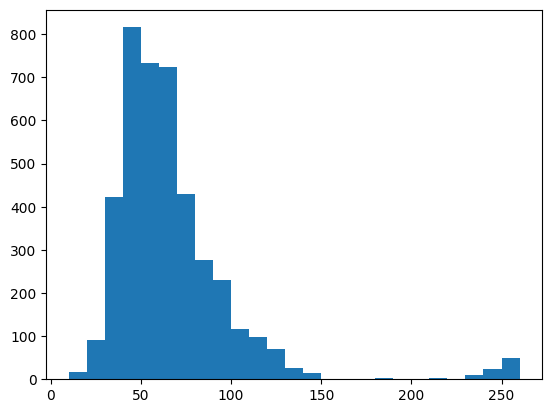

In [17]:
lengths = []
tqdm_loader = tqdm(train_df['relation_text'].fillna("").values, total=len(train_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
    
# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {config.MAX_LEN}")
_ = plt.hist(lengths, bins=25)

In [18]:
def prepare_input(cfg, text, tokenizer):
    """
    This function tokenizes the input text with the configured padding and truncation. Then,
    returns the input dictionary, which contains the following keys: "input_ids",
    "token_type_ids" and "attention_mask". Each value is a torch.tensor.
    :param cfg: configuration class with a TOKENIZER attribute.
    :param text: a numpy array where each value is a text as string.
    :return inputs: python dictionary where values are torch tensors.
    """
    inputs = tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.MAX_LEN,
        padding='max_length', # TODO: check padding to max sequence in batch
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # TODO: check dtypes
    return inputs


def collate(inputs):
    """
    It truncates the inputs to the maximum sequence length in the batch. 
    """
    mask_len = int(inputs["attention_mask"].sum(axis=1).max()) # Get batch's max sequence length
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


class CustomDataset(Dataset):
    def __init__(self, cfg, df, tokenizer):
        self.cfg = cfg
        self.texts = df['relation_text'].values
        self.labels = df['labels'].values
        self.tokenizer = tokenizer
        self.text_ids = df['document'].values
        self.num_classes = 12  # Number of unique classes

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)        
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.long)
        output["document"] = self.text_ids[item]
        return output


One sample from the dataset should look as following:
```python
{
	'inputs': {
		'input_ids': tensor([1, 279, 883, ..., 0, 0]),
		'token_type_ids': tensor([0, 0, 0, ..., 0, 0]),
		'attention_mask': tensor([1, 1, 1, ..., 0, 0])
	},
	'label': tensor([0.0]),
	'document': '000e8c3c7ddb'
}
```
You can check it by running the cell below.

In [19]:
if True:
    # ======== SPLIT ==========
    fold = 0
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['labels'].values
    print(valid_folds['labels'].nunique())

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # === Let's check one sample ===
    sample = train_dataset[0]
    print(f"Encoding keys: {sample.keys()} \n") 
    print(sample)

12
Encoding keys: dict_keys(['inputs', 'labels', 'document']) 

{'inputs': {'input_ids': tensor([50281,   510,  5522,   310,  5939,   762, 11963,  4214,  5259,  4637,
          285,  2130,   387,  3944,  1358, 37813,    15,  9906,    15,   681,
           16, 11264,    16,   570,    86,   409,   522, 33385,   964,   209,
        50282,   378,    14, 17736,   209, 50282, 11963,   209, 50282,   378,
           14, 31495, 13745,  1793,   209, 50282,  5522, 50282, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 502

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

In [20]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        # Load config by inferencing it from the model name.
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)

        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)

        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()

        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 12)
        self._init_weights(self.fc)

    def _init_weights(self, module):
        """
        This method initializes weights for different types of layers. The type of layers
        supported are nn.Linear, nn.Embedding and nn.LayerNorm.
        """
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        """
        This method makes a forward pass through the model, get the last hidden state (embedding)
        and pass it through the MeanPooling layer.
        """
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***
    
- [torch.cuda.amp.GradScaler](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler): This class helps writing compute efficient training loops, so we dont get OOM errors. Also, one common error in any large deep learning model is the problem of underflowing gradients (i.e. your gradients are too small to take into account). `float16` tensors often don't take into account extremely small variations. To prevent this we can scale our gradients by some factor so that they aren't flushed to zero. Not to be confused with vanishing gradients, this gradients still might contribute to the learning process however are skipped because of computational limits.
- [torch.autocast](https://pytorch.org/docs/stable/amp.html#torch.autocast)

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0

    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items(): # send each tensor value to `device`
                inputs[k] = v.to(device)
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.APEX):
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader),
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0]))

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            document_ids = batch.pop("document")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader))))

    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict[""] = document_ids
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [22]:
def train_loop(folds, fold):

    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    # train_folds = pd.concat([train_folds, valid_folds]).reset_index(drop=True)
    valid_labels = valid_folds["labels"].values

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # ======== MODEL ==========
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
    model.to(device)

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=config.ENCODER_LR,
                                                decoder_lr=config.DECODER_LR,
                                                weight_decay=config.WEIGHT_DECAY)
    optimizer = AdamW(
        optimizer_parameters,
        lr=config.ENCODER_LR,
        eps=config.EPS,
        betas=config.BETAS
    )


    num_train_steps = int(len(train_folds) / config.BATCH_SIZE_TRAIN * config.EPOCHS)
    scheduler = get_scheduler(config, optimizer, num_train_steps)

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    best_val_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best val score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")

    predictions = torch.load(paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth",
                             map_location=torch.device('cpu'))['predictions']
    valid_folds["preds"] = predictions

    torch.cuda.empty_cache()
    gc.collect()

    return valid_folds

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [23]:
if __name__ == '__main__':
    def get_result(oof_df):
        labels = oof_df["labels"].values
        preds = oof_df["preds"].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if config.TRAIN:
        oof_df = pd.DataFrame()
        for fold in range(config.FOLDS):
            if fold == 0:
                _oof_df = train_loop(train_df, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)

========== Fold: 0 training ==========


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

2025-04-13 00:47:56.889113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744505277.071734      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744505277.124763      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

W0413 00:48:20.593000 19 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT compiled_embeddings /usr/local/lib/python3.11/dist-packages/transformers/models/modernbert/modeling_modernbert.py line 212 
W0413 00:48:20.593000 19 torch/_dynamo/convert_frame.py:1125] due to: 
W0413 00:48:20.593000 19 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W0413 00:48:20.593000 19 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W0413 00:48:20.593000 19 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W0413 00:48:20.593000 19 torch/_dynamo/convert_frame.py:1125]                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
W0413 00:48:20.593000 19 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W0413 00:48:20.593000 19 torch/_dynamo/convert_f

Epoch: [1][0/48] Elapsed 0m 13s (remain 10m 51s) Loss: 2.7660 Grad: inf  LR: 0.00003996  
Epoch: [1][20/48] Elapsed 2m 23s (remain 3m 4s) Loss: 1.7288 Grad: 51924.0000  LR: 0.00003914  
Epoch: [1][40/48] Elapsed 4m 41s (remain 0m 48s) Loss: 1.3167 Grad: 68721.5781  LR: 0.00003832  
Epoch: [1][47/48] Elapsed 5m 21s (remain 0m 0s) Loss: 1.2249 Grad: 180961.1406  LR: 0.00003803  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7340 


Epoch 1 - avg_train_loss: 1.2249  avg_val_loss: 0.6208  time: 334s
Epoch 1 - Score: 0.6189
Epoch 1 - Save Best val score: 0.6189 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6208 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [2][0/48] Elapsed 0m 7s (remain 5m 32s) Loss: 0.5979 Grad: inf  LR: 0.00003799  
Epoch: [2][20/48] Elapsed 2m 28s (remain 3m 10s) Loss: 0.5758 Grad: 199684.4375  LR: 0.00003717  
Epoch: [2][40/48] Elapsed 4m 36s (remain 0m 47s) Loss: 0.5708 Grad: 127257.7422  LR: 0.00003634  
Epoch: [2][47/48] Elapsed 5m 26s (remain 0m 0s) Loss: 0.5607 Grad: 75576.7578  LR: 0.00003606  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7576 


Epoch 2 - avg_train_loss: 0.5607  avg_val_loss: 0.5756  time: 339s
Epoch 2 - Score: 0.7596
Epoch 2 - Save Best val score: 0.7596 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.5756 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [3][0/48] Elapsed 0m 7s (remain 5m 47s) Loss: 0.3765 Grad: 293359.4062  LR: 0.00003602  
Epoch: [3][20/48] Elapsed 2m 14s (remain 2m 52s) Loss: 0.5004 Grad: 260294.6406  LR: 0.00003520  
Epoch: [3][40/48] Elapsed 4m 29s (remain 0m 46s) Loss: 0.4896 Grad: 91950.8438  LR: 0.00003437  
Epoch: [3][47/48] Elapsed 5m 11s (remain 0m 0s) Loss: 0.4909 Grad: 45689.0430  LR: 0.00003409  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5472 


Epoch 3 - avg_train_loss: 0.4909  avg_val_loss: 0.5061  time: 325s
Epoch 3 - Score: 0.7687
Epoch 3 - Save Best val score: 0.7687 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.5061 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [4][0/48] Elapsed 0m 7s (remain 5m 47s) Loss: 0.4796 Grad: 288455.2812  LR: 0.00003405  
Epoch: [4][20/48] Elapsed 2m 16s (remain 2m 56s) Loss: 0.4412 Grad: 252522.7969  LR: 0.00003322  
Epoch: [4][40/48] Elapsed 4m 33s (remain 0m 46s) Loss: 0.4281 Grad: 242991.6094  LR: 0.00003240  
Epoch: [4][47/48] Elapsed 5m 8s (remain 0m 0s) Loss: 0.4136 Grad: 230663.9219  LR: 0.00003211  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.3360 


Epoch 4 - avg_train_loss: 0.4136  avg_val_loss: 0.3544  time: 321s
Epoch 4 - Score: 0.8733
Epoch 4 - Save Best val score: 0.8733 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3544 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [5][0/48] Elapsed 0m 7s (remain 5m 48s) Loss: 0.3265 Grad: 321879.0312  LR: 0.00003207  
Epoch: [5][20/48] Elapsed 2m 27s (remain 3m 9s) Loss: 0.1954 Grad: 398385.9062  LR: 0.00003125  
Epoch: [5][40/48] Elapsed 4m 34s (remain 0m 46s) Loss: 0.2052 Grad: inf  LR: 0.00003043  
Epoch: [5][47/48] Elapsed 5m 24s (remain 0m 0s) Loss: 0.1975 Grad: 198274.7812  LR: 0.00003014  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.3175 


Epoch 5 - avg_train_loss: 0.1975  avg_val_loss: 0.2114  time: 337s
Epoch 5 - Score: 0.9176
Epoch 5 - Save Best val score: 0.9176 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.2114 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [6][0/48] Elapsed 0m 6s (remain 5m 24s) Loss: 0.0980 Grad: 172795.0000  LR: 0.00003010  
Epoch: [6][20/48] Elapsed 2m 22s (remain 3m 2s) Loss: 0.1088 Grad: 289169.7812  LR: 0.00002928  
Epoch: [6][40/48] Elapsed 4m 42s (remain 0m 48s) Loss: 0.1138 Grad: 230946.5781  LR: 0.00002846  
Epoch: [6][47/48] Elapsed 5m 29s (remain 0m 0s) Loss: 0.1096 Grad: 369107.2500  LR: 0.00002817  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.3357 


Epoch 6 - avg_train_loss: 0.1096  avg_val_loss: 0.2076  time: 342s
Epoch 6 - Score: 0.9397
Epoch 6 - Save Best val score: 0.9397 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.2076 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [7][0/48] Elapsed 0m 7s (remain 5m 51s) Loss: 0.0593 Grad: 123478.1875  LR: 0.00002813  
Epoch: [7][20/48] Elapsed 2m 23s (remain 3m 4s) Loss: 0.0493 Grad: 776549.6875  LR: 0.00002731  
Epoch: [7][40/48] Elapsed 4m 35s (remain 0m 46s) Loss: 0.0602 Grad: 175352.7969  LR: 0.00002649  
Epoch: [7][47/48] Elapsed 5m 10s (remain 0m 0s) Loss: 0.0659 Grad: 107889.3828  LR: 0.00002620  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.3313 


Epoch 7 - avg_train_loss: 0.0659  avg_val_loss: 0.2454  time: 323s
Epoch 7 - Score: 0.9349


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.2454 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [8][0/48] Elapsed 0m 4s (remain 3m 8s) Loss: 0.0272 Grad: 129253.1328  LR: 0.00002616  
Epoch: [8][20/48] Elapsed 2m 18s (remain 2m 58s) Loss: 0.0545 Grad: 91174.9688  LR: 0.00002534  
Epoch: [8][40/48] Elapsed 4m 34s (remain 0m 46s) Loss: 0.0643 Grad: 53407.1211  LR: 0.00002452  
Epoch: [8][47/48] Elapsed 5m 18s (remain 0m 0s) Loss: 0.0661 Grad: 501188.7812  LR: 0.00002423  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.4599 


Epoch 8 - avg_train_loss: 0.0661  avg_val_loss: 0.3369  time: 332s
Epoch 8 - Score: 0.9325


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3369 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [9][0/48] Elapsed 0m 7s (remain 5m 47s) Loss: 0.1118 Grad: 1275575.1250  LR: 0.00002419  
Epoch: [9][20/48] Elapsed 2m 20s (remain 3m 0s) Loss: 0.0871 Grad: 635256.0000  LR: 0.00002337  
Epoch: [9][40/48] Elapsed 4m 26s (remain 0m 45s) Loss: 0.0810 Grad: 162977.9062  LR: 0.00002255  
Epoch: [9][47/48] Elapsed 5m 14s (remain 0m 0s) Loss: 0.0746 Grad: 144450.7656  LR: 0.00002226  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5289 


Epoch 9 - avg_train_loss: 0.0746  avg_val_loss: 0.2701  time: 327s
Epoch 9 - Score: 0.9379


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.2701 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [10][0/48] Elapsed 0m 7s (remain 5m 50s) Loss: 0.0053 Grad: 85837.5469  LR: 0.00002222  
Epoch: [10][20/48] Elapsed 2m 14s (remain 2m 52s) Loss: 0.0434 Grad: 249829.8125  LR: 0.00002140  
Epoch: [10][40/48] Elapsed 4m 15s (remain 0m 43s) Loss: 0.0450 Grad: 14839.4033  LR: 0.00002057  
Epoch: [10][47/48] Elapsed 5m 1s (remain 0m 0s) Loss: 0.0525 Grad: 80557.8828  LR: 0.00002029  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5966 


Epoch 10 - avg_train_loss: 0.0525  avg_val_loss: 0.3191  time: 314s
Epoch 10 - Score: 0.9430
Epoch 10 - Save Best val score: 0.9430 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3191 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [11][0/48] Elapsed 0m 7s (remain 5m 48s) Loss: 0.0032 Grad: 10458.4424  LR: 0.00002025  
Epoch: [11][20/48] Elapsed 2m 19s (remain 2m 59s) Loss: 0.0426 Grad: 200093.2188  LR: 0.00001943  
Epoch: [11][40/48] Elapsed 4m 37s (remain 0m 47s) Loss: 0.0363 Grad: 122333.1406  LR: 0.00001860  
Epoch: [11][47/48] Elapsed 5m 19s (remain 0m 0s) Loss: 0.0326 Grad: 40460.8633  LR: 0.00001832  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.4879 


Epoch 11 - avg_train_loss: 0.0326  avg_val_loss: 0.3048  time: 332s
Epoch 11 - Score: 0.9463
Epoch 11 - Save Best val score: 0.9463 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3048 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [12][0/48] Elapsed 0m 6s (remain 5m 24s) Loss: 0.0011 Grad: 10068.2803  LR: 0.00001828  
Epoch: [12][20/48] Elapsed 2m 14s (remain 2m 52s) Loss: 0.0119 Grad: 1043540.5625  LR: 0.00001745  
Epoch: [12][40/48] Elapsed 4m 25s (remain 0m 45s) Loss: 0.0092 Grad: 625.0983  LR: 0.00001663  
Epoch: [12][47/48] Elapsed 5m 7s (remain 0m 0s) Loss: 0.0115 Grad: 92467.6484  LR: 0.00001634  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.4785 


Epoch 12 - avg_train_loss: 0.0115  avg_val_loss: 0.3612  time: 320s
Epoch 12 - Score: 0.9493
Epoch 12 - Save Best val score: 0.9493 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3612 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [13][0/48] Elapsed 0m 6s (remain 5m 24s) Loss: 0.0003 Grad: 835.1678  LR: 0.00001630  
Epoch: [13][20/48] Elapsed 2m 14s (remain 2m 53s) Loss: 0.0058 Grad: 259.0003  LR: 0.00001548  
Epoch: [13][40/48] Elapsed 4m 27s (remain 0m 45s) Loss: 0.0063 Grad: 572.8431  LR: 0.00001466  
Epoch: [13][47/48] Elapsed 5m 15s (remain 0m 0s) Loss: 0.0054 Grad: 1415.0546  LR: 0.00001437  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.4830 


Epoch 13 - avg_train_loss: 0.0054  avg_val_loss: 0.3679  time: 328s
Epoch 13 - Score: 0.9470


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3679 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [14][0/48] Elapsed 0m 7s (remain 5m 50s) Loss: 0.0002 Grad: 401.1984  LR: 0.00001433  
Epoch: [14][20/48] Elapsed 2m 20s (remain 3m 0s) Loss: 0.0009 Grad: 286.2083  LR: 0.00001351  
Epoch: [14][40/48] Elapsed 4m 26s (remain 0m 45s) Loss: 0.0049 Grad: 272.2695  LR: 0.00001269  
Epoch: [14][47/48] Elapsed 5m 16s (remain 0m 0s) Loss: 0.0042 Grad: 365.3797  LR: 0.00001240  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5833 


Epoch 14 - avg_train_loss: 0.0042  avg_val_loss: 0.3501  time: 329s
Epoch 14 - Score: 0.9568
Epoch 14 - Save Best val score: 0.9568 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3501 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [15][0/48] Elapsed 0m 7s (remain 5m 32s) Loss: 0.0001 Grad: 110.3863  LR: 0.00001236  
Epoch: [15][20/48] Elapsed 2m 22s (remain 3m 3s) Loss: 0.0002 Grad: 182.7222  LR: 0.00001154  
Epoch: [15][40/48] Elapsed 4m 34s (remain 0m 46s) Loss: 0.0006 Grad: 101.1084  LR: 0.00001072  
Epoch: [15][47/48] Elapsed 5m 22s (remain 0m 0s) Loss: 0.0005 Grad: 453.7436  LR: 0.00001043  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5725 


Epoch 15 - avg_train_loss: 0.0005  avg_val_loss: 0.3715  time: 335s
Epoch 15 - Score: 0.9568
Epoch 15 - Save Best val score: 0.9568 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3715 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [16][0/48] Elapsed 0m 6s (remain 5m 24s) Loss: 0.0001 Grad: 126.7403  LR: 0.00001039  
Epoch: [16][20/48] Elapsed 2m 18s (remain 2m 58s) Loss: 0.0001 Grad: 80.0235  LR: 0.00000957  
Epoch: [16][40/48] Elapsed 4m 24s (remain 0m 45s) Loss: 0.0003 Grad: 83.4444  LR: 0.00000875  
Epoch: [16][47/48] Elapsed 5m 5s (remain 0m 0s) Loss: 0.0003 Grad: 73.5550  LR: 0.00000846  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5772 


Epoch 16 - avg_train_loss: 0.0003  avg_val_loss: 0.3822  time: 318s
Epoch 16 - Score: 0.9591
Epoch 16 - Save Best val score: 0.9591 Model


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3822 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [17][0/48] Elapsed 0m 3s (remain 2m 28s) Loss: 0.0001 Grad: 72.1068  LR: 0.00000842  
Epoch: [17][20/48] Elapsed 2m 11s (remain 2m 48s) Loss: 0.0001 Grad: 130.1800  LR: 0.00000760  
Epoch: [17][40/48] Elapsed 4m 32s (remain 0m 46s) Loss: 0.0001 Grad: 111.9588  LR: 0.00000678  
Epoch: [17][47/48] Elapsed 5m 24s (remain 0m 0s) Loss: 0.0001 Grad: 103.2628  LR: 0.00000649  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5788 


Epoch 17 - avg_train_loss: 0.0001  avg_val_loss: 0.3851  time: 337s
Epoch 17 - Score: 0.9591


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3851 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [18][0/48] Elapsed 0m 7s (remain 5m 31s) Loss: 0.0000 Grad: 67.3266  LR: 0.00000645  
Epoch: [18][20/48] Elapsed 2m 29s (remain 3m 12s) Loss: 0.0014 Grad: 86.9875  LR: 0.00000563  
Epoch: [18][40/48] Elapsed 4m 50s (remain 0m 49s) Loss: 0.0008 Grad: 61.3141  LR: 0.00000480  
Epoch: [18][47/48] Elapsed 5m 35s (remain 0m 0s) Loss: 0.0007 Grad: 75.2778  LR: 0.00000452  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5911 


Epoch 18 - avg_train_loss: 0.0007  avg_val_loss: 0.3869  time: 349s
Epoch 18 - Score: 0.9585


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3869 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [19][0/48] Elapsed 0m 7s (remain 5m 50s) Loss: 0.0001 Grad: 61.8347  LR: 0.00000448  
Epoch: [19][20/48] Elapsed 2m 12s (remain 2m 50s) Loss: 0.0001 Grad: 162.2191  LR: 0.00000366  
Epoch: [19][40/48] Elapsed 4m 38s (remain 0m 47s) Loss: 0.0001 Grad: 62.7103  LR: 0.00000283  
Epoch: [19][47/48] Elapsed 5m 26s (remain 0m 0s) Loss: 0.0001 Grad: 76.8913  LR: 0.00000255  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5918 


Epoch 19 - avg_train_loss: 0.0001  avg_val_loss: 0.3891  time: 340s
Epoch 19 - Score: 0.9585


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3891 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [20][0/48] Elapsed 0m 3s (remain 2m 39s) Loss: 0.0001 Grad: 56.9400  LR: 0.00000251  
Epoch: [20][20/48] Elapsed 2m 11s (remain 2m 49s) Loss: 0.0001 Grad: 79.7584  LR: 0.00000168  
Epoch: [20][40/48] Elapsed 4m 32s (remain 0m 46s) Loss: 0.0001 Grad: 88.7077  LR: 0.00000086  
Epoch: [20][47/48] Elapsed 5m 19s (remain 0m 0s) Loss: 0.0001 Grad: 50.0440  LR: 0.00000057  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5878 


Epoch 20 - avg_train_loss: 0.0001  avg_val_loss: 0.3897  time: 333s
Epoch 20 - Score: 0.9585


EVAL: [16/17] Elapsed 0m 12s (remain 0m 0s) Loss: 0.3897 


========== Fold: 0 result ==========
Score: 0.9591
========== CV ==========
Score: 0.9591


### <b><span style='color:#F1A424'>Confusion Matrix</span></b>


Text(0.5, 1.0, 'Confusion Matrix')

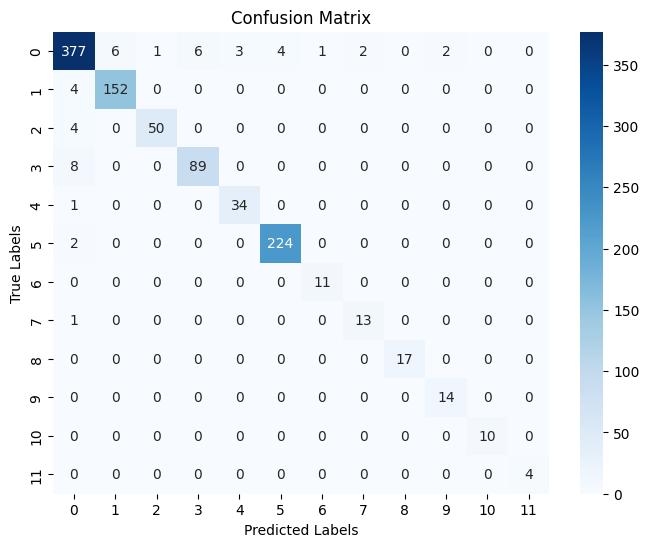

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix

# Assuming df is your pandas DataFrame
true_labels = oof_df["labels"].values
predicted_labels = oof_df["preds"].values

# Get the unique classes from both true and predicted labels
classes = np.unique(np.concatenate((true_labels, predicted_labels)))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [25]:
!zip -r output.zip /kaggle/working/output

  adding: kaggle/working/output/ (stored 0%)
  adding: kaggle/working/output/answerdotai_ModernBERT-large_fold_0_best.pth (deflated 7%)
  adding: kaggle/working/output/oof_df.csv (deflated 94%)
  adding: kaggle/working/output/tokenizer/ (stored 0%)
  adding: kaggle/working/output/tokenizer/tokenizer.json (deflated 82%)
  adding: kaggle/working/output/tokenizer/tokenizer_config.json (deflated 95%)
  adding: kaggle/working/output/tokenizer/special_tokens_map.json (deflated 79%)
  adding: kaggle/working/output/config.pth (deflated 52%)
